<a href="https://colab.research.google.com/github/AloniRegev/Defense-Against-Adversarial-Examples-in-NN/blob/main/Feature_Squeezing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impotrts:

In [ ]:
from torch._C import NoneType
import torch
import torchvision
import torchvision.datasets as datasets
from torch import optim
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchsummary import summary

# for adversary
import copy
from PIL import Image
# import scipy.signal as sg
import scipy.ndimage as sg

import cv2 as cv 

# Datasets:

In [ ]:
def load_dataset():
    transform_train = transforms.Compose([
        # agmentation below
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # regular normalization
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    # Normalize the test set same as training set without augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

    


    print(f' trainset: {trainset}')
    # print(f' trainset shape: {trainset.size()}')

    ## script to find mean
    # data = trainset.data / 255  # data is numpy array
    #
    # mean = data.mean(axis=(0, 1, 2))
    # std = data.std(axis=(0, 1, 2))
    # print(f"Mean : {mean}   STD: {std}")  # Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

    cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True,
                                     transform=transform_test)  # transform_test
    cifar_trainset, cifar_valset = data.random_split(trainset, [int(len(trainset) * 0.8), int(len(
        trainset) * 0.2)])  # split the trainset to trainset and validation set in 80%-20% retio

    print('train set len', len(cifar_trainset))
    print('validation set len', len(cifar_valset))
    print('test set len', len(cifar_testset))

    number_workers = 0
    if device == torch.device('cuda'):
        number_workers = 2
    train_loader = data.DataLoader(cifar_trainset, shuffle=True, batch_size=64, num_workers=number_workers)
    
    val_loader = data.DataLoader(cifar_valset, shuffle=False, batch_size=64, num_workers=number_workers)
    test_loader = data.DataLoader(cifar_testset, shuffle=False, batch_size=64, num_workers=number_workers)

    test_for_adv = data.DataLoader(cifar_testset, shuffle=False, batch_size=1)
    train_for_adv = data.DataLoader(cifar_trainset, shuffle=True, batch_size=1)
    return train_loader, val_loader, test_loader, test_for_adv, train_for_adv


# Feature Squeezing Modle:

In [ ]:
class CNN_model(nn.Module):  # TODO: fix so I get correct dimensions of output
    def __init__(self):
        super(CNN_model, self).__init__()
        self.feature_extractor = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1),

        )

    def forward(self, x):
        # conv layers
        features = self.feature_extractor(x)
        # print("features shape:", features.shape)

        # final non fully connected
        class_scores = self.classifier(features)
        # print("class_scores shape:", class_scores.shape)
        class_scores = torch.reshape(class_scores, (class_scores.size(dim=0), class_scores.size(dim=1)))
        # print("class_scores shape:", class_scores.shape)

        return class_scores

# Train:

In [ ]:
def plot_graph(list, title):
    plt.plot(list)
    plt.title(title)
    plt.show()

In [ ]:
def applidBlurr(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert from tensor
    npimg = np.transpose(npimg, (1, 2, 0)) # tranpos for image view
    # npimg= cv.medianBlur(npimg, 3) # applied median blurr
    npimg= sg.median_filter(npimg, size=2, mode="mirror") # applied median blurr

    # back to tensor
    img = np.transpose(npimg, (2, 0, 1))
    img= img*2-0.5

    return img

In [ ]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def FS_train_data(model, epochs, learning_rate, loss_function, train_loader, valid_loader, patience=4):
    loss_arr = []
    avg_train_loss_arr, avg_val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []
    # Early stopping  parameters
    last_loss = 100  # initializing max loss as high unreachable value
    trigger_times = 0
    PATH = './checkpoint'
    total, correct = 0.0, 0.0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    print(type(images))
    print(images.shape)
    print(labels.shape)

    for epoch in range(epochs):
        model.train()  # defining we're training so can use dropout, batch norm

        for i, (inputs, labels) in enumerate(train_loader, 0):
            # if device == torch.device('cuda'):
           
            inputs = inputs.cpu()
            # inputs = inputs.to(device)

            labels = labels.to(device)


            imshow(inputs[0])
            inputs= [applidBlurr(img) for img in inputs]
            inputs=torch.Tensor(inputs).to(device)
            imshow(inputs[0])

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss.backward()
            optimizer.step()

            # Show progress
            if i % 100 == 0 or i == len(train_loader):
                # print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, i, len(train_loader), loss.item()))
                print("Iteration: {0} | Loss: {1} | index {2} ".format(epoch, loss.item(), i))

            total += inputs.shape[0]
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

        # print("total is: {0}, len(train_loader): {1}, correct pred num is: {2}".format(total, len(train_loader), correct))
        train_acc = (correct / total)
        print('Accuracy: in train', train_acc)
        train_acc_arr.append(train_acc.item())

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))
        # Early stopping
        current_loss, avg_val_loss, val_acc = FS_validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        avg_val_loss_arr.append(avg_val_loss.item())
        val_acc_arr.append(val_acc.item())

        if current_loss > last_loss:
            trigger_times += 1
            # print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break  # exit loop, print data

        else:
            # print('trigger times did not increase:' , trigger_times)
            torch.save(model.state_dict(), PATH)
            trigger_times = 0

        last_loss = current_loss

    model.load_state_dict(torch.load(PATH))
    plot_graph(loss_arr, "generic network training loss")

    plt.plot(avg_train_loss_arr, label='train loss')
    # Plot another line on the same chart/graph
    plt.plot(avg_val_loss_arr, label='val loss')
    plt.title("avg train loss vs avg validation loss")
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.savefig('./outputs_q1/avg_train_loss_vs_avg_validation_loss.png')
    plt.show()

    plt.plot(train_acc_arr, label='train accuracy')
    # Plot another line on the same chart/graph
    plt.plot(val_acc_arr, label='validation accuracy')
    plt.title("avg train acc vs avg validation acc")
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    # plt.savefig('./outputs_q1/avg_train_acc_vs_avg_validation_acc.png')
    plt.show()

    return model

In [ ]:
def FS_validation_data(model, valid_loader):
    model.eval()
    total = 0
    correct = 0
    loss_total = 0.0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in valid_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_valid = loss_fn(output, labels)
            loss_arr.append(loss_valid.item())
            loss_total += loss_valid.item()

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    # plot_graph(loss_arr, "generic network valid loss")
    acc = (correct / total)
    print('Accuracy: in validation', acc)

    return (loss_total / len(valid_loader)), np.mean(loss_arr), acc


In [ ]:
def FS_test_data(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in test_loader:
            # data = [applidBlurr(img) for img in data]
            # data = torch.Tensor(data)
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_test = loss_fn(output, labels)
            loss_arr.append(loss_test.item())

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    plot_graph(loss_arr, "generic network test loss")

    print('Accuracy: in test', (correct / total))

# Main:

CUDA available. Training on GPU
Files already downloaded and verified
 trainset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )
Files already downloaded and verified
train set len 40000
validation set len 10000
test set len 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d

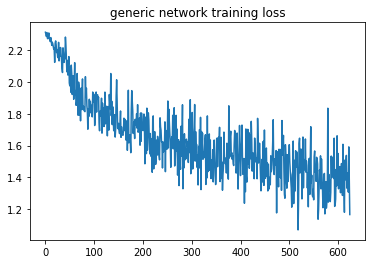

Accuracy: in validation tensor(0.4912, device='cuda:0')
The Current Loss by validation data: 1.3921303722509153
Iteration: 1 | Loss: 1.3835653066635132 | index 0 
Iteration: 1 | Loss: 1.3528106212615967 | index 100 
Iteration: 1 | Loss: 1.1756495237350464 | index 200 
Iteration: 1 | Loss: 1.2217665910720825 | index 300 
Iteration: 1 | Loss: 1.0527019500732422 | index 400 
Iteration: 1 | Loss: 1.0278661251068115 | index 500 
Iteration: 1 | Loss: 1.4045836925506592 | index 600 
Accuracy: in train tensor(0.4638, device='cuda:0')


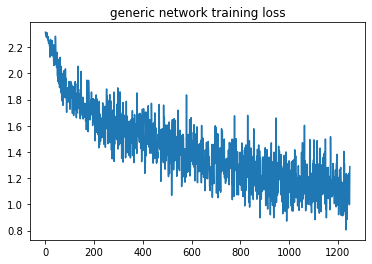

Accuracy: in validation tensor(0.5724, device='cuda:0')
The Current Loss by validation data: 1.230958077937934
Iteration: 2 | Loss: 0.8739878535270691 | index 0 
Iteration: 2 | Loss: 0.9887132048606873 | index 100 
Iteration: 2 | Loss: 0.9513942003250122 | index 200 
Iteration: 2 | Loss: 0.8171378970146179 | index 300 
Iteration: 2 | Loss: 1.2259365320205688 | index 400 
Iteration: 2 | Loss: 0.802517831325531 | index 500 
Iteration: 2 | Loss: 0.8593268990516663 | index 600 
Accuracy: in train tensor(0.5188, device='cuda:0')


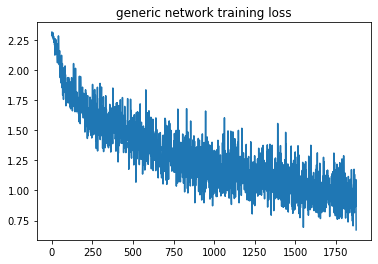

Accuracy: in validation tensor(0.6510, device='cuda:0')
The Current Loss by validation data: 0.9767601391312423
Iteration: 3 | Loss: 0.9371267557144165 | index 0 
Iteration: 3 | Loss: 0.7595845460891724 | index 100 
Iteration: 3 | Loss: 0.9053547382354736 | index 200 
Iteration: 3 | Loss: 1.019666075706482 | index 300 
Iteration: 3 | Loss: 0.8698102831840515 | index 400 
Iteration: 3 | Loss: 0.914633572101593 | index 500 
Iteration: 3 | Loss: 0.7093892693519592 | index 600 
Accuracy: in train tensor(0.5574, device='cuda:0')


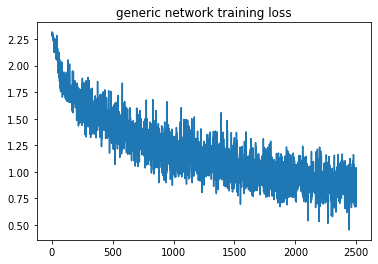

Accuracy: in validation tensor(0.6858, device='cuda:0')
The Current Loss by validation data: 0.8771717806530607
Iteration: 4 | Loss: 1.0167443752288818 | index 0 
Iteration: 4 | Loss: 0.9731273055076599 | index 100 
Iteration: 4 | Loss: 0.8991432189941406 | index 200 
Iteration: 4 | Loss: 0.638015627861023 | index 300 
Iteration: 4 | Loss: 0.6666786074638367 | index 400 
Iteration: 4 | Loss: 0.7558562755584717 | index 500 
Iteration: 4 | Loss: 0.740575909614563 | index 600 
Accuracy: in train tensor(0.5870, device='cuda:0')


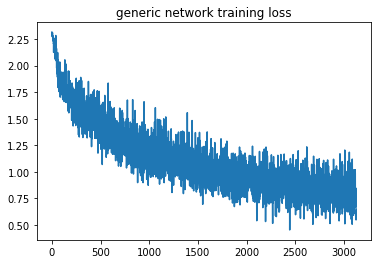

Accuracy: in validation tensor(0.7166, device='cuda:0')
The Current Loss by validation data: 0.7986991099870888
Iteration: 5 | Loss: 1.153684377670288 | index 0 
Iteration: 5 | Loss: 1.0023207664489746 | index 100 
Iteration: 5 | Loss: 0.9883353114128113 | index 200 
Iteration: 5 | Loss: 0.9660122990608215 | index 300 
Iteration: 5 | Loss: 0.5938332080841064 | index 400 
Iteration: 5 | Loss: 0.8797335624694824 | index 500 
Iteration: 5 | Loss: 0.6795235872268677 | index 600 
Accuracy: in train tensor(0.6112, device='cuda:0')


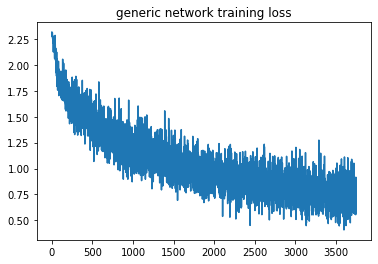

Accuracy: in validation tensor(0.7274, device='cuda:0')
The Current Loss by validation data: 0.7632560616086244
Iteration: 6 | Loss: 0.6392199993133545 | index 0 
Iteration: 6 | Loss: 0.6202205419540405 | index 100 
Iteration: 6 | Loss: 0.8076269030570984 | index 200 
Iteration: 6 | Loss: 0.7808443307876587 | index 300 
Iteration: 6 | Loss: 0.7264434099197388 | index 400 
Iteration: 6 | Loss: 0.6559058427810669 | index 500 
Iteration: 6 | Loss: 0.8290384411811829 | index 600 
Accuracy: in train tensor(0.6314, device='cuda:0')


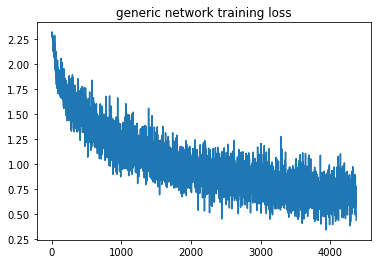

Accuracy: in validation tensor(0.7558, device='cuda:0')
The Current Loss by validation data: 0.6866915055141327
Iteration: 7 | Loss: 0.7128832936286926 | index 0 
Iteration: 7 | Loss: 0.6550071835517883 | index 100 
Iteration: 7 | Loss: 0.5897937417030334 | index 200 
Iteration: 7 | Loss: 0.5439414978027344 | index 300 
Iteration: 7 | Loss: 0.7639188766479492 | index 400 
Iteration: 7 | Loss: 0.5878486037254333 | index 500 
Iteration: 7 | Loss: 0.6575546860694885 | index 600 
Accuracy: in train tensor(0.6490, device='cuda:0')


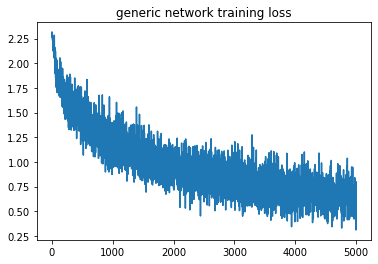

Accuracy: in validation tensor(0.7600, device='cuda:0')
The Current Loss by validation data: 0.6739568767274261
Iteration: 8 | Loss: 0.8353750705718994 | index 0 
Iteration: 8 | Loss: 0.6499828696250916 | index 100 
Iteration: 8 | Loss: 0.43032306432724 | index 200 
Iteration: 8 | Loss: 0.7004832625389099 | index 300 
Iteration: 8 | Loss: 0.6978204846382141 | index 400 
Iteration: 8 | Loss: 0.480062872171402 | index 500 
Iteration: 8 | Loss: 0.5679968595504761 | index 600 
Accuracy: in train tensor(0.6642, device='cuda:0')


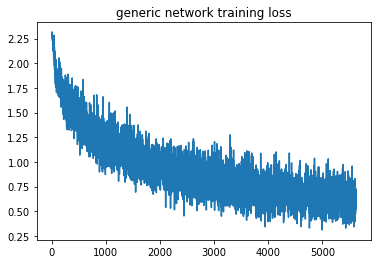

Accuracy: in validation tensor(0.7576, device='cuda:0')
The Current Loss by validation data: 0.7089613829828372
Iteration: 9 | Loss: 0.7295149564743042 | index 0 
Iteration: 9 | Loss: 0.3535616397857666 | index 100 
Iteration: 9 | Loss: 0.6784018278121948 | index 200 
Iteration: 9 | Loss: 0.4410861134529114 | index 300 
Iteration: 9 | Loss: 0.6742069125175476 | index 400 
Iteration: 9 | Loss: 0.48582714796066284 | index 500 
Iteration: 9 | Loss: 0.764157772064209 | index 600 
Accuracy: in train tensor(0.6776, device='cuda:0')


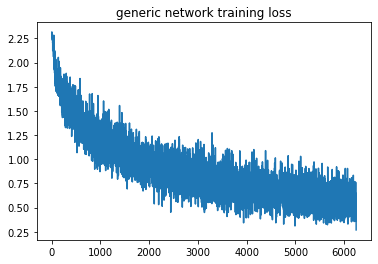

Accuracy: in validation tensor(0.7674, device='cuda:0')
The Current Loss by validation data: 0.6507447950399605
Iteration: 10 | Loss: 0.7504197955131531 | index 0 
Iteration: 10 | Loss: 0.38457250595092773 | index 100 
Iteration: 10 | Loss: 0.6615917086601257 | index 200 
Iteration: 10 | Loss: 0.548833429813385 | index 300 
Iteration: 10 | Loss: 0.5388378500938416 | index 400 
Iteration: 10 | Loss: 0.40404239296913147 | index 500 
Iteration: 10 | Loss: 0.645900309085846 | index 600 
Accuracy: in train tensor(0.6897, device='cuda:0')


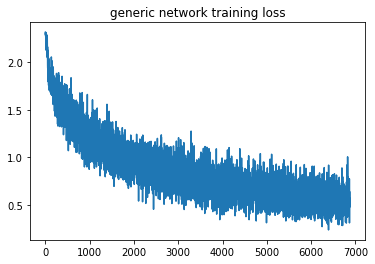

Accuracy: in validation tensor(0.8007, device='cuda:0')
The Current Loss by validation data: 0.5792345296425424
Iteration: 11 | Loss: 0.6073742508888245 | index 0 
Iteration: 11 | Loss: 0.7073630094528198 | index 100 
Iteration: 11 | Loss: 0.49564406275749207 | index 200 
Iteration: 11 | Loss: 0.46677762269973755 | index 300 
Iteration: 11 | Loss: 0.4279806911945343 | index 400 
Iteration: 11 | Loss: 0.31243622303009033 | index 500 
Iteration: 11 | Loss: 0.48765140771865845 | index 600 
Accuracy: in train tensor(0.7005, device='cuda:0')


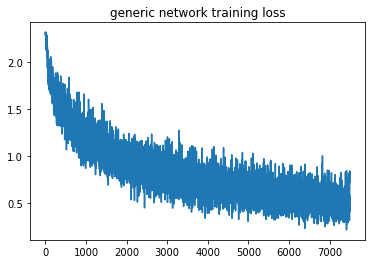

Accuracy: in validation tensor(0.7888, device='cuda:0')
The Current Loss by validation data: 0.6071755300471737
Iteration: 12 | Loss: 0.5068954825401306 | index 0 
Iteration: 12 | Loss: 0.2944934368133545 | index 100 
Iteration: 12 | Loss: 0.6309617161750793 | index 200 
Iteration: 12 | Loss: 0.5174013376235962 | index 300 
Iteration: 12 | Loss: 0.36097195744514465 | index 400 
Iteration: 12 | Loss: 0.5892661213874817 | index 500 
Iteration: 12 | Loss: 0.404977947473526 | index 600 
Accuracy: in train tensor(0.7103, device='cuda:0')


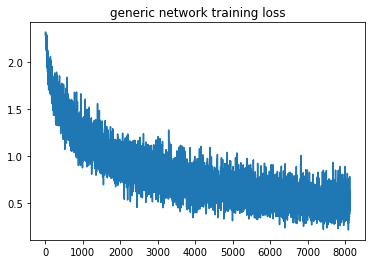

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4f5619cb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4f5619cb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Accuracy: in validation tensor(0.8187, device='cuda:0')
The Current Loss by validation data: 0.5226507348239802


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4f5619cb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4f5619cb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Iteration: 13 | Loss: 0.4912426769733429 | index 0 


AssertionError: can only test a child process


Iteration: 13 | Loss: 0.5051622986793518 | index 100 
Iteration: 13 | Loss: 0.18010807037353516 | index 200 
Iteration: 13 | Loss: 0.6003055572509766 | index 300 
Iteration: 13 | Loss: 0.398535817861557 | index 400 
Iteration: 13 | Loss: 0.5532271265983582 | index 500 
Iteration: 13 | Loss: 0.5518345236778259 | index 600 
Accuracy: in train tensor(0.7192, device='cuda:0')


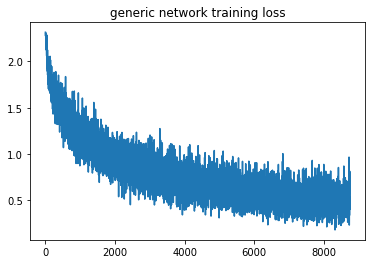

Accuracy: in validation tensor(0.8149, device='cuda:0')
The Current Loss by validation data: 0.5404168000076986
Iteration: 14 | Loss: 0.26373809576034546 | index 0 
Iteration: 14 | Loss: 0.3177448809146881 | index 100 
Iteration: 14 | Loss: 0.4474581778049469 | index 200 
Iteration: 14 | Loss: 0.4395096004009247 | index 300 
Iteration: 14 | Loss: 0.416573703289032 | index 400 
Iteration: 14 | Loss: 0.25962018966674805 | index 500 
Iteration: 14 | Loss: 0.4409777522087097 | index 600 
Accuracy: in train tensor(0.7276, device='cuda:0')


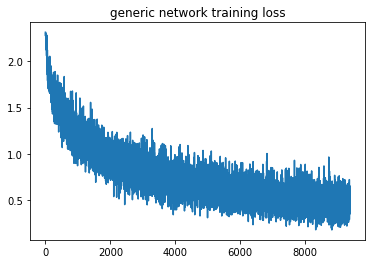

Accuracy: in validation tensor(0.8160, device='cuda:0')
The Current Loss by validation data: 0.5277041359122392
Iteration: 15 | Loss: 0.34948214888572693 | index 0 
Iteration: 15 | Loss: 0.5263519883155823 | index 100 
Iteration: 15 | Loss: 0.20875848829746246 | index 200 
Iteration: 15 | Loss: 0.45809248089790344 | index 300 
Iteration: 15 | Loss: 0.3405880630016327 | index 400 
Iteration: 15 | Loss: 0.4926222860813141 | index 500 
Iteration: 15 | Loss: 0.4240438640117645 | index 600 
Accuracy: in train tensor(0.7353, device='cuda:0')


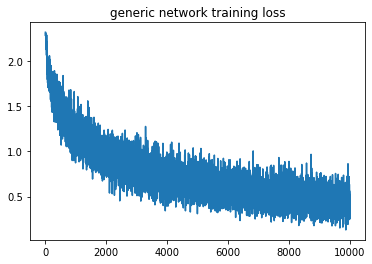

Accuracy: in validation tensor(0.8153, device='cuda:0')
The Current Loss by validation data: 0.5421928630512991
Iteration: 16 | Loss: 0.48356375098228455 | index 0 
Iteration: 16 | Loss: 0.581477701663971 | index 100 
Iteration: 16 | Loss: 0.251254677772522 | index 200 
Iteration: 16 | Loss: 0.2742080092430115 | index 300 
Iteration: 16 | Loss: 0.34009355306625366 | index 400 
Iteration: 16 | Loss: 0.35254108905792236 | index 500 
Iteration: 16 | Loss: 0.3938506245613098 | index 600 
Accuracy: in train tensor(0.7425, device='cuda:0')


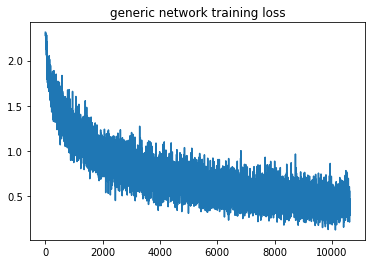

Accuracy: in validation tensor(0.8316, device='cuda:0')
The Current Loss by validation data: 0.49437154914922776
Iteration: 17 | Loss: 0.4030730128288269 | index 0 
Iteration: 17 | Loss: 0.2776568531990051 | index 100 
Iteration: 17 | Loss: 0.625654399394989 | index 200 
Iteration: 17 | Loss: 0.33127206563949585 | index 300 
Iteration: 17 | Loss: 0.5031111240386963 | index 400 
Iteration: 17 | Loss: 0.43633636832237244 | index 500 
Iteration: 17 | Loss: 0.5202239751815796 | index 600 
Accuracy: in train tensor(0.7492, device='cuda:0')


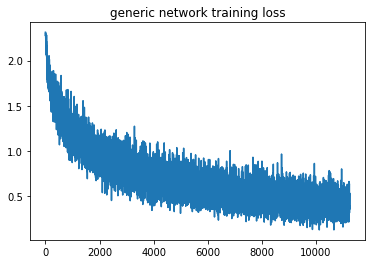

Accuracy: in validation tensor(0.8380, device='cuda:0')
The Current Loss by validation data: 0.4777616002377431
Iteration: 18 | Loss: 0.38192862272262573 | index 0 
Iteration: 18 | Loss: 0.3176056444644928 | index 100 
Iteration: 18 | Loss: 0.29220709204673767 | index 200 
Iteration: 18 | Loss: 0.5617307424545288 | index 300 
Iteration: 18 | Loss: 0.458335816860199 | index 400 
Iteration: 18 | Loss: 0.42924243211746216 | index 500 
Iteration: 18 | Loss: 0.33314448595046997 | index 600 
Accuracy: in train tensor(0.7554, device='cuda:0')


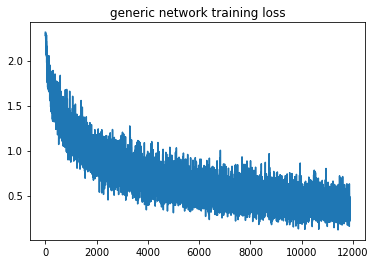

Accuracy: in validation tensor(0.8360, device='cuda:0')
The Current Loss by validation data: 0.48483077147204406
Iteration: 19 | Loss: 0.37834101915359497 | index 0 
Iteration: 19 | Loss: 0.24662141501903534 | index 100 
Iteration: 19 | Loss: 0.4962879419326782 | index 200 
Iteration: 19 | Loss: 0.4203470051288605 | index 300 
Iteration: 19 | Loss: 0.47564733028411865 | index 400 
Iteration: 19 | Loss: 0.4648982882499695 | index 500 
Iteration: 19 | Loss: 0.36153703927993774 | index 600 
Accuracy: in train tensor(0.7613, device='cuda:0')


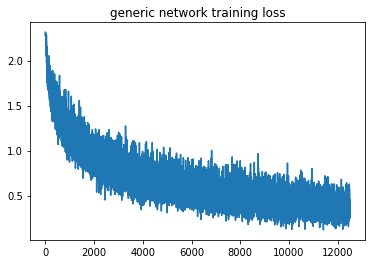

Accuracy: in validation tensor(0.8355, device='cuda:0')
The Current Loss by validation data: 0.4865375770505067
Iteration: 20 | Loss: 0.3599182665348053 | index 0 
Iteration: 20 | Loss: 0.32755571603775024 | index 100 
Iteration: 20 | Loss: 0.2526383399963379 | index 200 
Iteration: 20 | Loss: 0.3080596327781677 | index 300 
Iteration: 20 | Loss: 0.5080050826072693 | index 400 
Iteration: 20 | Loss: 0.28273749351501465 | index 500 
Iteration: 20 | Loss: 0.2860552966594696 | index 600 
Accuracy: in train tensor(0.7669, device='cuda:0')


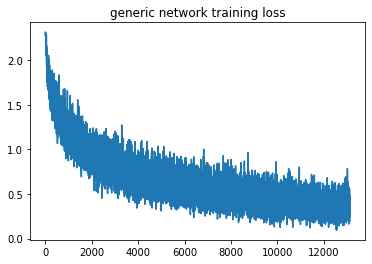

Accuracy: in validation tensor(0.8381, device='cuda:0')
The Current Loss by validation data: 0.4825673433625774
Iteration: 21 | Loss: 0.38270848989486694 | index 0 
Iteration: 21 | Loss: 0.3810124397277832 | index 100 
Iteration: 21 | Loss: 0.26818743348121643 | index 200 
Iteration: 21 | Loss: 0.26740968227386475 | index 300 
Iteration: 21 | Loss: 0.2673799395561218 | index 400 
Iteration: 21 | Loss: 0.4519771635532379 | index 500 
Iteration: 21 | Loss: 0.3957538902759552 | index 600 
Accuracy: in train tensor(0.7721, device='cuda:0')


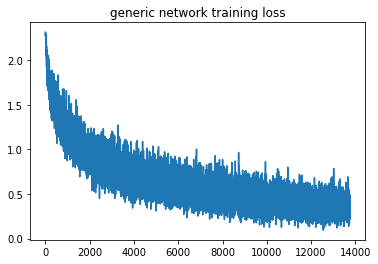

Accuracy: in validation tensor(0.8362, device='cuda:0')
The Current Loss by validation data: 0.4942035532681046
Iteration: 22 | Loss: 0.12357717007398605 | index 0 
Iteration: 22 | Loss: 0.3571135997772217 | index 100 
Iteration: 22 | Loss: 0.4270084798336029 | index 200 
Iteration: 22 | Loss: 0.5761445164680481 | index 300 
Iteration: 22 | Loss: 0.27887633442878723 | index 400 
Iteration: 22 | Loss: 0.43301841616630554 | index 500 
Iteration: 22 | Loss: 0.5623452067375183 | index 600 
Accuracy: in train tensor(0.7772, device='cuda:0')


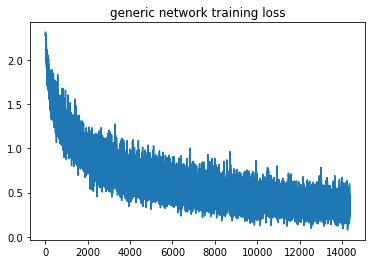

Accuracy: in validation tensor(0.8408, device='cuda:0')
The Current Loss by validation data: 0.4698083783221093
Iteration: 23 | Loss: 0.18834243714809418 | index 0 
Iteration: 23 | Loss: 0.4671969413757324 | index 100 
Iteration: 23 | Loss: 0.3022080659866333 | index 200 
Iteration: 23 | Loss: 0.2555808126926422 | index 300 
Iteration: 23 | Loss: 0.21076728403568268 | index 400 
Iteration: 23 | Loss: 0.33760690689086914 | index 500 
Iteration: 23 | Loss: 0.2909676730632782 | index 600 
Accuracy: in train tensor(0.7820, device='cuda:0')


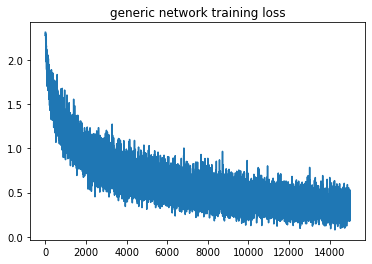

Accuracy: in validation tensor(0.8533, device='cuda:0')
The Current Loss by validation data: 0.4492961416958244
Iteration: 24 | Loss: 0.14580264687538147 | index 0 
Iteration: 24 | Loss: 0.18072259426116943 | index 100 
Iteration: 24 | Loss: 0.3957075774669647 | index 200 
Iteration: 24 | Loss: 0.25612539052963257 | index 300 
Iteration: 24 | Loss: 0.28383302688598633 | index 400 
Iteration: 24 | Loss: 0.25728902220726013 | index 500 
Iteration: 24 | Loss: 0.45882293581962585 | index 600 
Accuracy: in train tensor(0.7865, device='cuda:0')


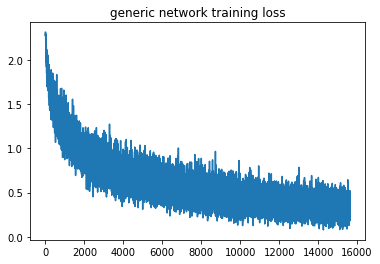

Accuracy: in validation tensor(0.8508, device='cuda:0')
The Current Loss by validation data: 0.45191203760113685
Iteration: 25 | Loss: 0.25380462408065796 | index 0 
Iteration: 25 | Loss: 0.32737842202186584 | index 100 
Iteration: 25 | Loss: 0.2309311032295227 | index 200 
Iteration: 25 | Loss: 0.3112097680568695 | index 300 
Iteration: 25 | Loss: 0.4642840623855591 | index 400 
Iteration: 25 | Loss: 0.39021965861320496 | index 500 
Iteration: 25 | Loss: 0.23437908291816711 | index 600 
Accuracy: in train tensor(0.7908, device='cuda:0')


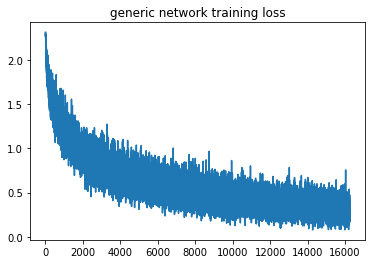

Accuracy: in validation tensor(0.8530, device='cuda:0')
The Current Loss by validation data: 0.4556496462244896
Iteration: 26 | Loss: 0.25137782096862793 | index 0 
Iteration: 26 | Loss: 0.28722184896469116 | index 100 
Iteration: 26 | Loss: 0.17275415360927582 | index 200 
Iteration: 26 | Loss: 0.2544373571872711 | index 300 
Iteration: 26 | Loss: 0.29690635204315186 | index 400 
Iteration: 26 | Loss: 0.2856576442718506 | index 500 
Iteration: 26 | Loss: 0.48446404933929443 | index 600 
Accuracy: in train tensor(0.7949, device='cuda:0')


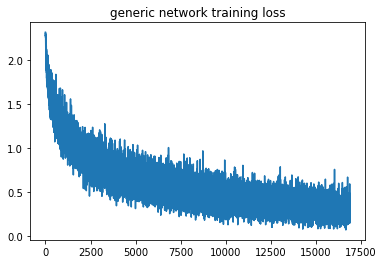

Accuracy: in validation tensor(0.8477, device='cuda:0')
The Current Loss by validation data: 0.4668213694243674
Iteration: 27 | Loss: 0.1941632777452469 | index 0 
Iteration: 27 | Loss: 0.43495383858680725 | index 100 
Iteration: 27 | Loss: 0.3578256368637085 | index 200 
Iteration: 27 | Loss: 0.25870728492736816 | index 300 
Iteration: 27 | Loss: 0.44216832518577576 | index 400 
Iteration: 27 | Loss: 0.27078011631965637 | index 500 
Iteration: 27 | Loss: 0.16794008016586304 | index 600 
Accuracy: in train tensor(0.7988, device='cuda:0')


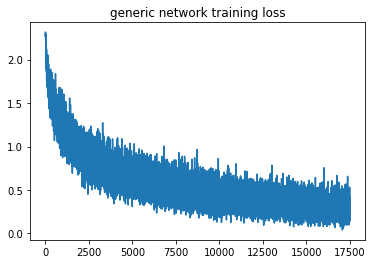

Accuracy: in validation tensor(0.8486, device='cuda:0')
The Current Loss by validation data: 0.46334082277337457
Iteration: 28 | Loss: 0.37131932377815247 | index 0 
Iteration: 28 | Loss: 0.17590704560279846 | index 100 
Iteration: 28 | Loss: 0.3029173016548157 | index 200 
Iteration: 28 | Loss: 0.23138128221035004 | index 300 
Iteration: 28 | Loss: 0.36876437067985535 | index 400 
Iteration: 28 | Loss: 0.27799394726753235 | index 500 
Iteration: 28 | Loss: 0.48162513971328735 | index 600 
Accuracy: in train tensor(0.8026, device='cuda:0')


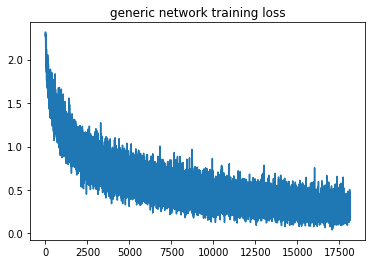

Accuracy: in validation tensor(0.8568, device='cuda:0')
The Current Loss by validation data: 0.4423975540194542
Iteration: 29 | Loss: 0.19248376786708832 | index 0 
Iteration: 29 | Loss: 0.3463781476020813 | index 100 
Iteration: 29 | Loss: 0.35209184885025024 | index 200 
Iteration: 29 | Loss: 0.4467620253562927 | index 300 
Iteration: 29 | Loss: 0.32463449239730835 | index 400 
Iteration: 29 | Loss: 0.292904794216156 | index 500 
Iteration: 29 | Loss: 0.2990051507949829 | index 600 
Accuracy: in train tensor(0.8062, device='cuda:0')


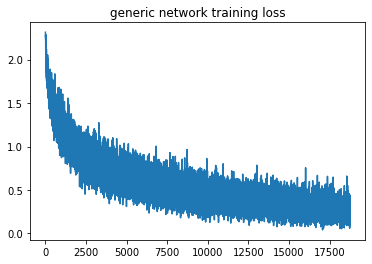

Accuracy: in validation tensor(0.8575, device='cuda:0')
The Current Loss by validation data: 0.43319937786099255
Iteration: 30 | Loss: 0.2045406848192215 | index 0 
Iteration: 30 | Loss: 0.19769355654716492 | index 100 
Iteration: 30 | Loss: 0.14069433510303497 | index 200 
Iteration: 30 | Loss: 0.24664463102817535 | index 300 
Iteration: 30 | Loss: 0.15844999253749847 | index 400 
Iteration: 30 | Loss: 0.22910456359386444 | index 500 
Iteration: 30 | Loss: 0.31929439306259155 | index 600 
Accuracy: in train tensor(0.8097, device='cuda:0')


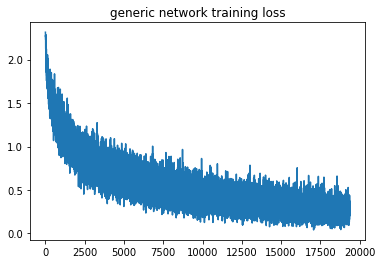

Accuracy: in validation tensor(0.8469, device='cuda:0')
The Current Loss by validation data: 0.5002633016200582
Iteration: 31 | Loss: 0.1948474794626236 | index 0 
Iteration: 31 | Loss: 0.07436776906251907 | index 100 
Iteration: 31 | Loss: 0.4799331724643707 | index 200 
Iteration: 31 | Loss: 0.18205904960632324 | index 300 
Iteration: 31 | Loss: 0.1882261037826538 | index 400 
Iteration: 31 | Loss: 0.18708765506744385 | index 500 
Iteration: 31 | Loss: 0.3404899537563324 | index 600 
Accuracy: in train tensor(0.8131, device='cuda:0')


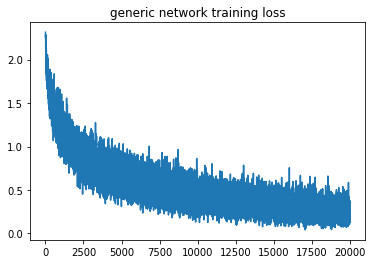

Accuracy: in validation tensor(0.8573, device='cuda:0')
The Current Loss by validation data: 0.4530243035049955
Iteration: 32 | Loss: 0.17841637134552002 | index 0 
Iteration: 32 | Loss: 0.27611321210861206 | index 100 
Iteration: 32 | Loss: 0.33272188901901245 | index 200 
Iteration: 32 | Loss: 0.35621878504753113 | index 300 
Iteration: 32 | Loss: 0.2417001724243164 | index 400 
Iteration: 32 | Loss: 0.1855183094739914 | index 500 
Iteration: 32 | Loss: 0.3059890568256378 | index 600 
Accuracy: in train tensor(0.8164, device='cuda:0')


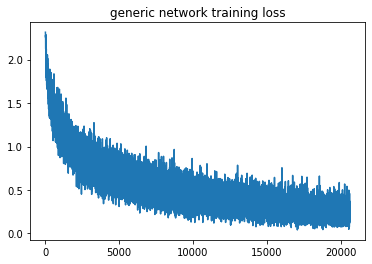

Accuracy: in validation tensor(0.8578, device='cuda:0')
The Current Loss by validation data: 0.4377193677767067
Iteration: 33 | Loss: 0.34711840748786926 | index 0 
Iteration: 33 | Loss: 0.20508593320846558 | index 100 
Iteration: 33 | Loss: 0.17015855014324188 | index 200 
Iteration: 33 | Loss: 0.14709562063217163 | index 300 
Iteration: 33 | Loss: 0.1681351661682129 | index 400 
Iteration: 33 | Loss: 0.36686888337135315 | index 500 
Iteration: 33 | Loss: 0.27520832419395447 | index 600 
Accuracy: in train tensor(0.8195, device='cuda:0')


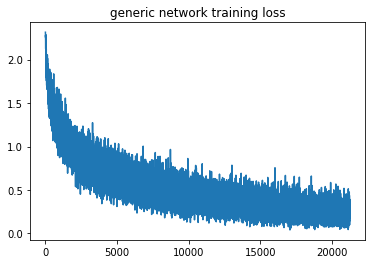

Accuracy: in validation tensor(0.8624, device='cuda:0')
The Current Loss by validation data: 0.4269962707522568
Iteration: 34 | Loss: 0.23186954855918884 | index 0 
Iteration: 34 | Loss: 0.1871458888053894 | index 100 
Iteration: 34 | Loss: 0.2591698169708252 | index 200 
Iteration: 34 | Loss: 0.2070097029209137 | index 300 
Iteration: 34 | Loss: 0.22180578112602234 | index 400 
Iteration: 34 | Loss: 0.29122331738471985 | index 500 
Iteration: 34 | Loss: 0.23247328400611877 | index 600 
Accuracy: in train tensor(0.8225, device='cuda:0')


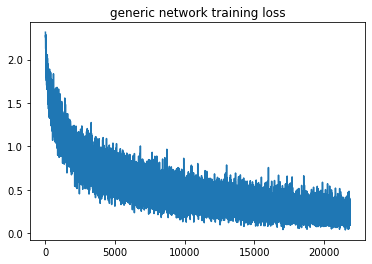

Accuracy: in validation tensor(0.8590, device='cuda:0')
The Current Loss by validation data: 0.43832862633428754
Iteration: 35 | Loss: 0.15773135423660278 | index 0 
Iteration: 35 | Loss: 0.14331308007240295 | index 100 
Iteration: 35 | Loss: 0.0916256532073021 | index 200 
Iteration: 35 | Loss: 0.2999829053878784 | index 300 
Iteration: 35 | Loss: 0.08557577431201935 | index 400 
Iteration: 35 | Loss: 0.19453854858875275 | index 500 
Iteration: 35 | Loss: 0.1956370770931244 | index 600 
Accuracy: in train tensor(0.8254, device='cuda:0')


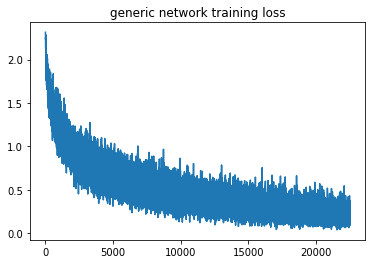

Accuracy: in validation tensor(0.8604, device='cuda:0')
The Current Loss by validation data: 0.45564278058565344
Iteration: 36 | Loss: 0.16128897666931152 | index 0 
Iteration: 36 | Loss: 0.23135104775428772 | index 100 
Iteration: 36 | Loss: 0.15449798107147217 | index 200 
Iteration: 36 | Loss: 0.27460965514183044 | index 300 
Iteration: 36 | Loss: 0.0777011513710022 | index 400 
Iteration: 36 | Loss: 0.26687708497047424 | index 500 
Iteration: 36 | Loss: 0.17767949402332306 | index 600 
Accuracy: in train tensor(0.8281, device='cuda:0')


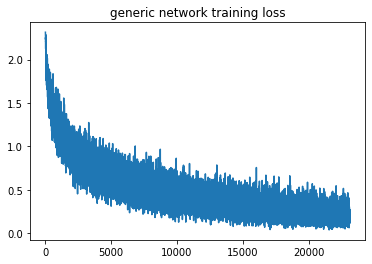

Accuracy: in validation tensor(0.8695, device='cuda:0')
The Current Loss by validation data: 0.4169332871486427
Iteration: 37 | Loss: 0.18442559242248535 | index 0 
Iteration: 37 | Loss: 0.16421093046665192 | index 100 
Iteration: 37 | Loss: 0.2661764323711395 | index 200 
Iteration: 37 | Loss: 0.2575111985206604 | index 300 
Iteration: 37 | Loss: 0.13659268617630005 | index 400 
Iteration: 37 | Loss: 0.22761322557926178 | index 500 
Iteration: 37 | Loss: 0.11334502696990967 | index 600 
Accuracy: in train tensor(0.8309, device='cuda:0')


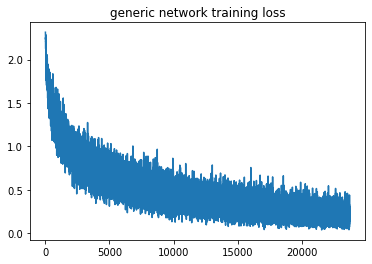

Accuracy: in validation tensor(0.8643, device='cuda:0')
The Current Loss by validation data: 0.45126825077518534
Iteration: 38 | Loss: 0.14162778854370117 | index 0 
Iteration: 38 | Loss: 0.09106498956680298 | index 100 
Iteration: 38 | Loss: 0.14350959658622742 | index 200 
Iteration: 38 | Loss: 0.18746185302734375 | index 300 
Iteration: 38 | Loss: 0.18523083627223969 | index 400 
Iteration: 38 | Loss: 0.1397646814584732 | index 500 
Iteration: 38 | Loss: 0.14206095039844513 | index 600 
Accuracy: in train tensor(0.8335, device='cuda:0')


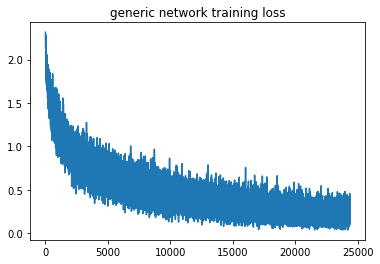

Accuracy: in validation tensor(0.8665, device='cuda:0')
The Current Loss by validation data: 0.4323808810893138
Iteration: 39 | Loss: 0.16554729640483856 | index 0 
Iteration: 39 | Loss: 0.21630223095417023 | index 100 
Iteration: 39 | Loss: 0.15991374850273132 | index 200 
Iteration: 39 | Loss: 0.1432715207338333 | index 300 
Iteration: 39 | Loss: 0.16307520866394043 | index 400 
Iteration: 39 | Loss: 0.11306966841220856 | index 500 
Iteration: 39 | Loss: 0.11704690009355545 | index 600 
Accuracy: in train tensor(0.8361, device='cuda:0')


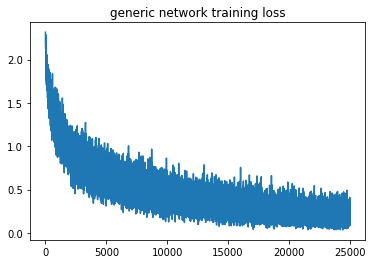

Accuracy: in validation tensor(0.8613, device='cuda:0')
The Current Loss by validation data: 0.4546235492275019
Iteration: 40 | Loss: 0.26169711351394653 | index 0 
Iteration: 40 | Loss: 0.26104971766471863 | index 100 
Iteration: 40 | Loss: 0.24775387346744537 | index 200 
Iteration: 40 | Loss: 0.09316292405128479 | index 300 
Iteration: 40 | Loss: 0.11233685165643692 | index 400 
Iteration: 40 | Loss: 0.1380711793899536 | index 500 
Iteration: 40 | Loss: 0.22760173678398132 | index 600 
Accuracy: in train tensor(0.8386, device='cuda:0')


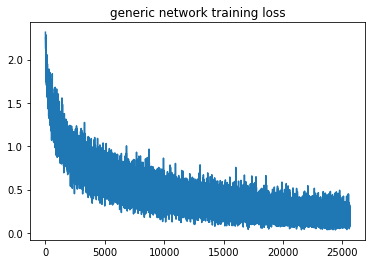

Accuracy: in validation tensor(0.8570, device='cuda:0')
The Current Loss by validation data: 0.473133449863856
Iteration: 41 | Loss: 0.1851506233215332 | index 0 
Iteration: 41 | Loss: 0.15326887369155884 | index 100 
Iteration: 41 | Loss: 0.16152700781822205 | index 200 
Iteration: 41 | Loss: 0.1596958041191101 | index 300 
Iteration: 41 | Loss: 0.24310283362865448 | index 400 
Iteration: 41 | Loss: 0.11828076839447021 | index 500 
Iteration: 41 | Loss: 0.08118219673633575 | index 600 
Accuracy: in train tensor(0.8410, device='cuda:0')


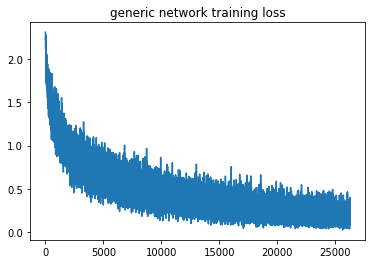

Accuracy: in validation tensor(0.8703, device='cuda:0')
The Current Loss by validation data: 0.422371330914224
Iteration: 42 | Loss: 0.1528645008802414 | index 0 
Iteration: 42 | Loss: 0.16369876265525818 | index 100 
Iteration: 42 | Loss: 0.12640777230262756 | index 200 
Iteration: 42 | Loss: 0.1910526305437088 | index 300 
Iteration: 42 | Loss: 0.10282500088214874 | index 400 
Iteration: 42 | Loss: 0.29491013288497925 | index 500 
Iteration: 42 | Loss: 0.15686370432376862 | index 600 
Accuracy: in train tensor(0.8433, device='cuda:0')


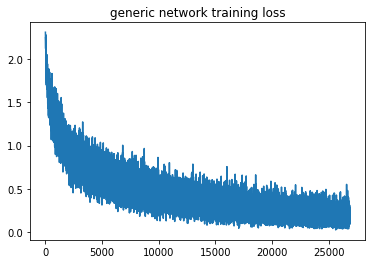

Accuracy: in validation tensor(0.8666, device='cuda:0')
The Current Loss by validation data: 0.44231750445950563
Iteration: 43 | Loss: 0.1202322468161583 | index 0 
Iteration: 43 | Loss: 0.12297568470239639 | index 100 
Iteration: 43 | Loss: 0.10982723534107208 | index 200 
Iteration: 43 | Loss: 0.12429900467395782 | index 300 
Iteration: 43 | Loss: 0.19530710577964783 | index 400 
Iteration: 43 | Loss: 0.1808725893497467 | index 500 
Iteration: 43 | Loss: 0.1644415408372879 | index 600 
Accuracy: in train tensor(0.8455, device='cuda:0')


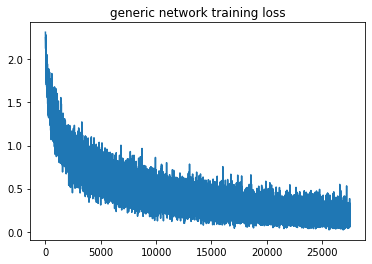

Accuracy: in validation tensor(0.8697, device='cuda:0')
The Current Loss by validation data: 0.44934889095224395
Iteration: 44 | Loss: 0.1338852196931839 | index 0 
Iteration: 44 | Loss: 0.09013035148382187 | index 100 
Iteration: 44 | Loss: 0.25412577390670776 | index 200 
Iteration: 44 | Loss: 0.11171989142894745 | index 300 
Iteration: 44 | Loss: 0.12399081885814667 | index 400 
Iteration: 44 | Loss: 0.1563149094581604 | index 500 
Iteration: 44 | Loss: 0.22979186475276947 | index 600 
Accuracy: in train tensor(0.8477, device='cuda:0')


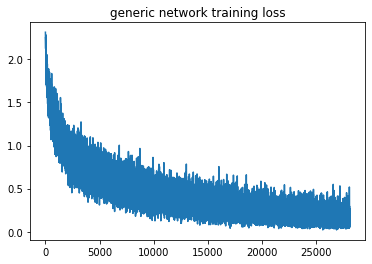

Accuracy: in validation tensor(0.8664, device='cuda:0')
The Current Loss by validation data: 0.4617200061963622
Iteration: 45 | Loss: 0.07453975826501846 | index 0 
Iteration: 45 | Loss: 0.11708242446184158 | index 100 
Iteration: 45 | Loss: 0.09355100989341736 | index 200 
Iteration: 45 | Loss: 0.09318041056394577 | index 300 
Iteration: 45 | Loss: 0.2924360930919647 | index 400 
Iteration: 45 | Loss: 0.1043858677148819 | index 500 
Iteration: 45 | Loss: 0.2633603811264038 | index 600 
Accuracy: in train tensor(0.8498, device='cuda:0')


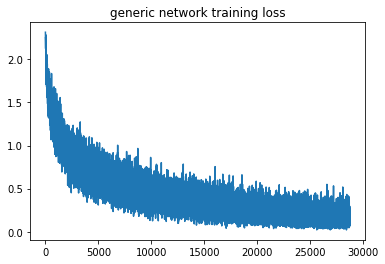

Accuracy: in validation tensor(0.8667, device='cuda:0')
The Current Loss by validation data: 0.4423430471853086
Iteration: 46 | Loss: 0.14186953008174896 | index 0 
Iteration: 46 | Loss: 0.15934231877326965 | index 100 
Iteration: 46 | Loss: 0.19323264062404633 | index 200 
Iteration: 46 | Loss: 0.23398442566394806 | index 300 
Iteration: 46 | Loss: 0.06852704286575317 | index 400 
Iteration: 46 | Loss: 0.09306436032056808 | index 500 
Iteration: 46 | Loss: 0.15598173439502716 | index 600 
Accuracy: in train tensor(0.8519, device='cuda:0')


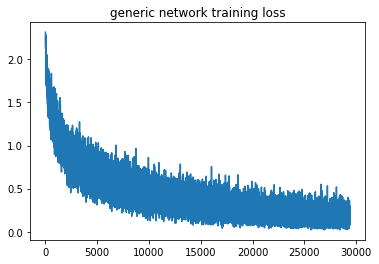

Accuracy: in validation tensor(0.8660, device='cuda:0')
The Current Loss by validation data: 0.438473009427262
Iteration: 47 | Loss: 0.1466287523508072 | index 0 
Iteration: 47 | Loss: 0.19145222008228302 | index 100 
Iteration: 47 | Loss: 0.23393885791301727 | index 200 
Iteration: 47 | Loss: 0.1612902581691742 | index 300 
Iteration: 47 | Loss: 0.1189388707280159 | index 400 
Iteration: 47 | Loss: 0.12822680175304413 | index 500 
Iteration: 47 | Loss: 0.12439582496881485 | index 600 
Accuracy: in train tensor(0.8539, device='cuda:0')


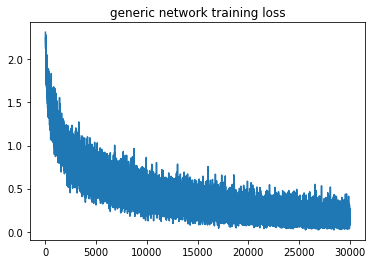

Accuracy: in validation tensor(0.8648, device='cuda:0')
The Current Loss by validation data: 0.4605827876811574
Iteration: 48 | Loss: 0.22855091094970703 | index 0 
Iteration: 48 | Loss: 0.10858991742134094 | index 100 
Iteration: 48 | Loss: 0.036331094801425934 | index 200 
Iteration: 48 | Loss: 0.03751431405544281 | index 300 
Iteration: 48 | Loss: 0.253776490688324 | index 400 
Iteration: 48 | Loss: 0.18873871862888336 | index 500 
Iteration: 48 | Loss: 0.11567222326993942 | index 600 
Accuracy: in train tensor(0.8559, device='cuda:0')


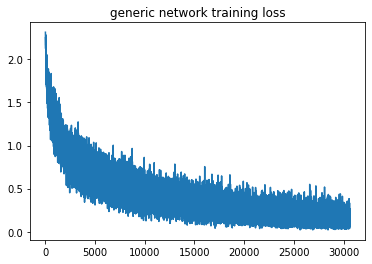

Accuracy: in validation tensor(0.8753, device='cuda:0')
The Current Loss by validation data: 0.43202341120144366
Iteration: 49 | Loss: 0.08899985253810883 | index 0 
Iteration: 49 | Loss: 0.2273961752653122 | index 100 
Iteration: 49 | Loss: 0.3870730698108673 | index 200 
Iteration: 49 | Loss: 0.04163435101509094 | index 300 
Iteration: 49 | Loss: 0.2626623511314392 | index 400 
Iteration: 49 | Loss: 0.1262020468711853 | index 500 
Iteration: 49 | Loss: 0.14783072471618652 | index 600 
Accuracy: in train tensor(0.8577, device='cuda:0')


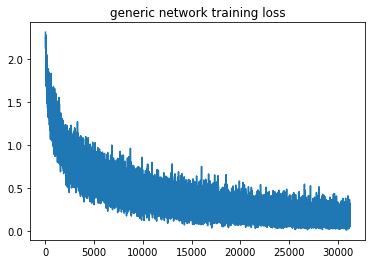

Accuracy: in validation tensor(0.8722, device='cuda:0')
The Current Loss by validation data: 0.4564167701514663
Iteration: 50 | Loss: 0.13199907541275024 | index 0 
Iteration: 50 | Loss: 0.1112021952867508 | index 100 
Iteration: 50 | Loss: 0.31064337491989136 | index 200 
Iteration: 50 | Loss: 0.08929252624511719 | index 300 
Iteration: 50 | Loss: 0.21067863702774048 | index 400 
Iteration: 50 | Loss: 0.07370349764823914 | index 500 
Iteration: 50 | Loss: 0.08678299188613892 | index 600 
Accuracy: in train tensor(0.8596, device='cuda:0')


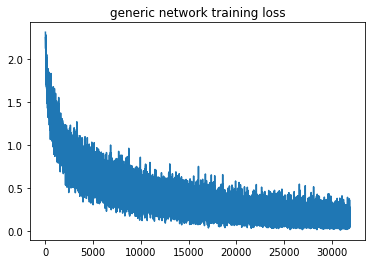

Accuracy: in validation tensor(0.8756, device='cuda:0')
The Current Loss by validation data: 0.447827569997994
Iteration: 51 | Loss: 0.15300783514976501 | index 0 
Iteration: 51 | Loss: 0.08767960965633392 | index 100 
Iteration: 51 | Loss: 0.047669731080532074 | index 200 
Iteration: 51 | Loss: 0.30174875259399414 | index 300 
Iteration: 51 | Loss: 0.2321387231349945 | index 400 
Iteration: 51 | Loss: 0.08694679290056229 | index 500 
Iteration: 51 | Loss: 0.1392967253923416 | index 600 
Accuracy: in train tensor(0.8613, device='cuda:0')


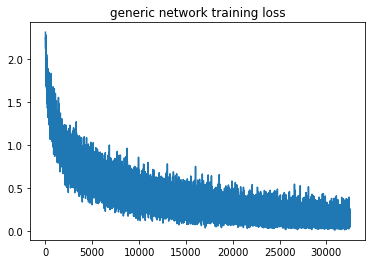

Accuracy: in validation tensor(0.8760, device='cuda:0')
The Current Loss by validation data: 0.42802028751866833
Iteration: 52 | Loss: 0.1274866759777069 | index 0 
Iteration: 52 | Loss: 0.042556215077638626 | index 100 
Iteration: 52 | Loss: 0.1705801635980606 | index 200 
Iteration: 52 | Loss: 0.2412557303905487 | index 300 
Iteration: 52 | Loss: 0.26579156517982483 | index 400 
Iteration: 52 | Loss: 0.18320100009441376 | index 500 
Iteration: 52 | Loss: 0.11149146407842636 | index 600 
Accuracy: in train tensor(0.8631, device='cuda:0')


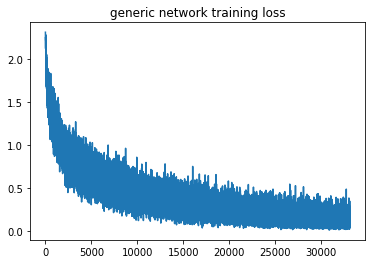

Accuracy: in validation tensor(0.8770, device='cuda:0')
The Current Loss by validation data: 0.42490064338514
Iteration: 53 | Loss: 0.20468470454216003 | index 0 
Iteration: 53 | Loss: 0.04332761839032173 | index 100 
Iteration: 53 | Loss: 0.26573604345321655 | index 200 
Iteration: 53 | Loss: 0.11330179125070572 | index 300 
Iteration: 53 | Loss: 0.11833243072032928 | index 400 
Iteration: 53 | Loss: 0.05744221806526184 | index 500 
Iteration: 53 | Loss: 0.24544088542461395 | index 600 
Accuracy: in train tensor(0.8648, device='cuda:0')


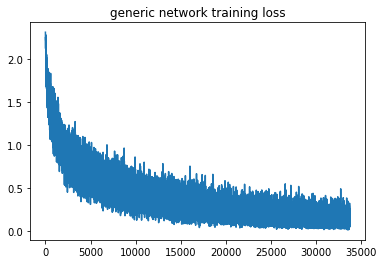

Accuracy: in validation tensor(0.8686, device='cuda:0')
The Current Loss by validation data: 0.4489503582571722
Iteration: 54 | Loss: 0.08365929871797562 | index 0 
Iteration: 54 | Loss: 0.08964166790246964 | index 100 
Iteration: 54 | Loss: 0.08168323338031769 | index 200 
Iteration: 54 | Loss: 0.04551738128066063 | index 300 
Iteration: 54 | Loss: 0.12089879810810089 | index 400 
Iteration: 54 | Loss: 0.04264023154973984 | index 500 
Iteration: 54 | Loss: 0.0908132791519165 | index 600 
Accuracy: in train tensor(0.8665, device='cuda:0')


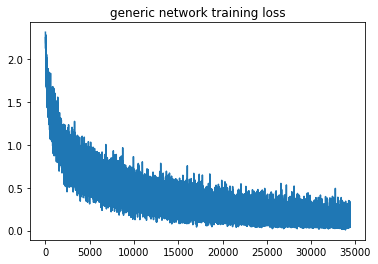

Accuracy: in validation tensor(0.8769, device='cuda:0')
The Current Loss by validation data: 0.4236587998308953
Iteration: 55 | Loss: 0.1092185452580452 | index 0 
Iteration: 55 | Loss: 0.1020180881023407 | index 100 
Iteration: 55 | Loss: 0.07550490647554398 | index 200 
Iteration: 55 | Loss: 0.11733725666999817 | index 300 
Iteration: 55 | Loss: 0.092729851603508 | index 400 
Iteration: 55 | Loss: 0.12720587849617004 | index 500 
Iteration: 55 | Loss: 0.1400771588087082 | index 600 
Accuracy: in train tensor(0.8681, device='cuda:0')


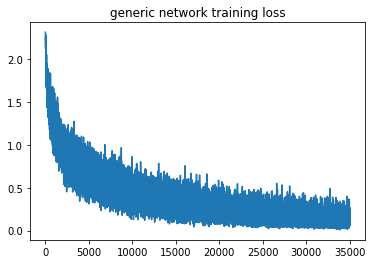

Accuracy: in validation tensor(0.8726, device='cuda:0')
The Current Loss by validation data: 0.44561805343552
Iteration: 56 | Loss: 0.05595074221491814 | index 0 
Iteration: 56 | Loss: 0.1079617440700531 | index 100 
Iteration: 56 | Loss: 0.08411290496587753 | index 200 
Iteration: 56 | Loss: 0.22381407022476196 | index 300 
Iteration: 56 | Loss: 0.138607457280159 | index 400 
Iteration: 56 | Loss: 0.06130499020218849 | index 500 
Iteration: 56 | Loss: 0.1942615807056427 | index 600 
Accuracy: in train tensor(0.8697, device='cuda:0')


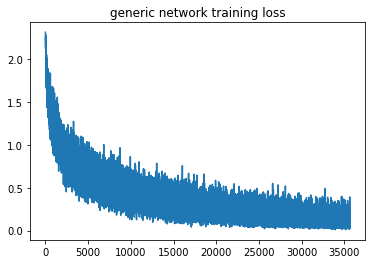

Accuracy: in validation tensor(0.8736, device='cuda:0')
The Current Loss by validation data: 0.43694080141889063
Iteration: 57 | Loss: 0.13292154669761658 | index 0 
Iteration: 57 | Loss: 0.05151878297328949 | index 100 
Iteration: 57 | Loss: 0.17455878853797913 | index 200 
Iteration: 57 | Loss: 0.09445066004991531 | index 300 
Iteration: 57 | Loss: 0.03783061355352402 | index 400 
Iteration: 57 | Loss: 0.08317025750875473 | index 500 
Iteration: 57 | Loss: 0.21640987694263458 | index 600 
Accuracy: in train tensor(0.8713, device='cuda:0')


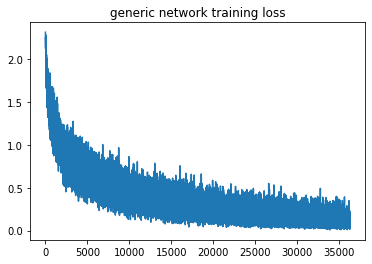

Accuracy: in validation tensor(0.8801, device='cuda:0')
The Current Loss by validation data: 0.4378107127490317
Iteration: 58 | Loss: 0.05903640016913414 | index 0 
Iteration: 58 | Loss: 0.11986438930034637 | index 100 
Iteration: 58 | Loss: 0.08128073811531067 | index 200 
Iteration: 58 | Loss: 0.07059932500123978 | index 300 
Iteration: 58 | Loss: 0.2719825208187103 | index 400 
Iteration: 58 | Loss: 0.10517951846122742 | index 500 
Iteration: 58 | Loss: 0.11814163625240326 | index 600 
Accuracy: in train tensor(0.8728, device='cuda:0')


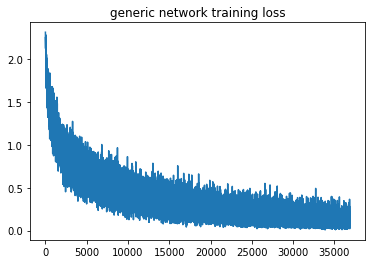

Accuracy: in validation tensor(0.8710, device='cuda:0')
The Current Loss by validation data: 0.4770057432733144
Iteration: 59 | Loss: 0.07053045183420181 | index 0 
Iteration: 59 | Loss: 0.18304885923862457 | index 100 
Iteration: 59 | Loss: 0.14938142895698547 | index 200 
Iteration: 59 | Loss: 0.07758156955242157 | index 300 
Iteration: 59 | Loss: 0.05351236090064049 | index 400 
Iteration: 59 | Loss: 0.06860898435115814 | index 500 
Iteration: 59 | Loss: 0.05665772035717964 | index 600 
Accuracy: in train tensor(0.8742, device='cuda:0')


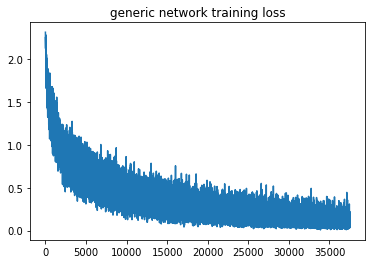

In [ ]:
if __name__ == '__main__':
    global device
    device = torch.device('cpu')
    # check if cuda is available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        device = torch.device('cuda')
        print("CUDA available. Training on GPU")
    else:
        print("CUDA is not available. Training on CPU")

    train_loader, val_loader, test_loader, test_for_adv, train_for_adv = load_dataset()
    batch_size = 64
    max_epochs = 80  # number of steps between evaluations
    loss_fn = nn.CrossEntropyLoss()

    model = CNN_model().to(device)  # with dropout, batch, without FC layers
    summary(model, input_size=(3, 32, 32))
    print(model)

    model = FS_train_data(model, 100, 0.0001, loss_fn, train_loader, val_loader)
    # torch.save(model.state_dict(), PATH)
    # PATH = './DeepFool/model.pth'
    # model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
    #model.load_state_dict(torch.load(PATH))
    FS_test_data(model, test_loader)
    # print('\n\nFinished Training model\n\n')

    # adversarial_train(model, 100, 0.0001, loss_fn, train_loader)
    #calling_deepfool(model, test_for_adv)

